In [1]:
# Import voxelize
import sys
sys.path.append('/appalachia/d6/yujie/voxelize-master/voxelize')
sys.path.append('/appalachia/d6/yujie/voxelize-master')
import voxelize
from voxelize import Voxelize
Voxelize.__init__(self=Voxelize, use_gpu=False, network_dir=None)
# Show figures inline
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
import matplotlib.colors as colors
# from meshoid import Meshoid
import utils_data as my
import utils_pk as pk
# Auto reload packages
%load_ext autoreload
%autoreload 2

plt.style.use('./niceplot2jay.mplstyle')

Only the CPU-only flavour of Voxelize is available!


In [2]:
# file = '/appalachia/d6/yujie/tmp/snapshot_600.hdf5'
file = '/appalachia/d5/DISK/from_pleiades/snapshots/gmcs0_wind4_gmc9/snapshot_550.hdf5'
# file = './data/snapshot_659_9.hdf5'
# Read the file
f = h5py.File(file, 'r')
# Load the data
rho = f["PartType0"]["Density"][:]
pos = f["PartType0"]["Coordinates"][:]
mass = f["PartType0"]["Masses"][:]
v = f["PartType0"]["Velocities"][:]
u = f['PartType0/InternalEnergy'][:]
xe = f['PartType0/ElectronAbundance'][:]
f.close()

In [3]:
# Voxelize require a more uniform coordinates
xmin, xmax = np.min(pos[:,0]), np.max(pos[:,0])
ymin, ymax = np.min(pos[:,1]), np.max(pos[:,1])
zmin, zmax = np.min(pos[:,2]), np.max(pos[:,2])

pos[:,0] -= xmin
pos[:,1] -= ymin
pos[:,2] -= zmin

# Prep for plot
res = 512 # resolution
xmin, xmax = np.min(pos[:,0]), np.max(pos[:,0])
ymin, ymax = np.min(pos[:,1]), np.max(pos[:,1])
# Grid
xgrid = np.linspace(xmin, xmax, res)
ygrid = np.linspace(ymin, ymax, res)
X, Y = np.meshgrid(xgrid, ygrid)

In [11]:
# Get radii
rho /= 2**3 # increase R by 2 while fix mass
V = mass/rho # volume = mass/density
R = ((3*V)/(4*np.pi))**(1/3) #* 2

In [12]:
# Count grid! Divide by this to get volume weighted f
count = np.ones(len(R))
count_grid = Voxelize.__call__(self=Voxelize, box_L=1, coords=pos, radii=R, field=count, box=512)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
root_add_process : started ...
workers_process : started ...
workers using 35 threads.
Workers processed 1699446657 numbers, of which were
	0.000e+00 exact calculations (R<Rmin),
	9.452e+08 exact calculations (R>Rmax),
	7.542e+08 trivial calculations,
	0.000e+00 interpolations.

workers_process : ended.
Root processed 1699446657 numbers in 51880 CPU-chunks.
root_add_process : ended.
voxelize_gpu function took 226.9365 seconds
In the end, 0 in cpu_queue


In [13]:
# Interpolate rho
rho_grid = Voxelize.__call__(self=Voxelize, box_L=1, coords=pos, radii=R, field=rho, box=512)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
root_add_process : started ...
workers_process : started ...
workers using 35 threads.
Workers processed 1699446657 numbers, of which were
	0.000e+00 exact calculations (R<Rmin),
	9.452e+08 exact calculations (R>Rmax),
	7.542e+08 trivial calculations,
	0.000e+00 interpolations.

workers_process : ended.
Root processed 1699446657 numbers in 51881 CPU-chunks.
root_add_process : ended.
voxelize_gpu function took 227.0368 seconds
In the end, 0 in cpu_queue


In [14]:
# Get volume weighted rho
rho_volume_weighted_grid = rho_grid / count_grid

/tmp/ipykernel_476948/1327031151.py:2: RuntimeWarning: invalid value encountered in true_divide
  rho_volume_weighted_grid = rho_grid / count_grid


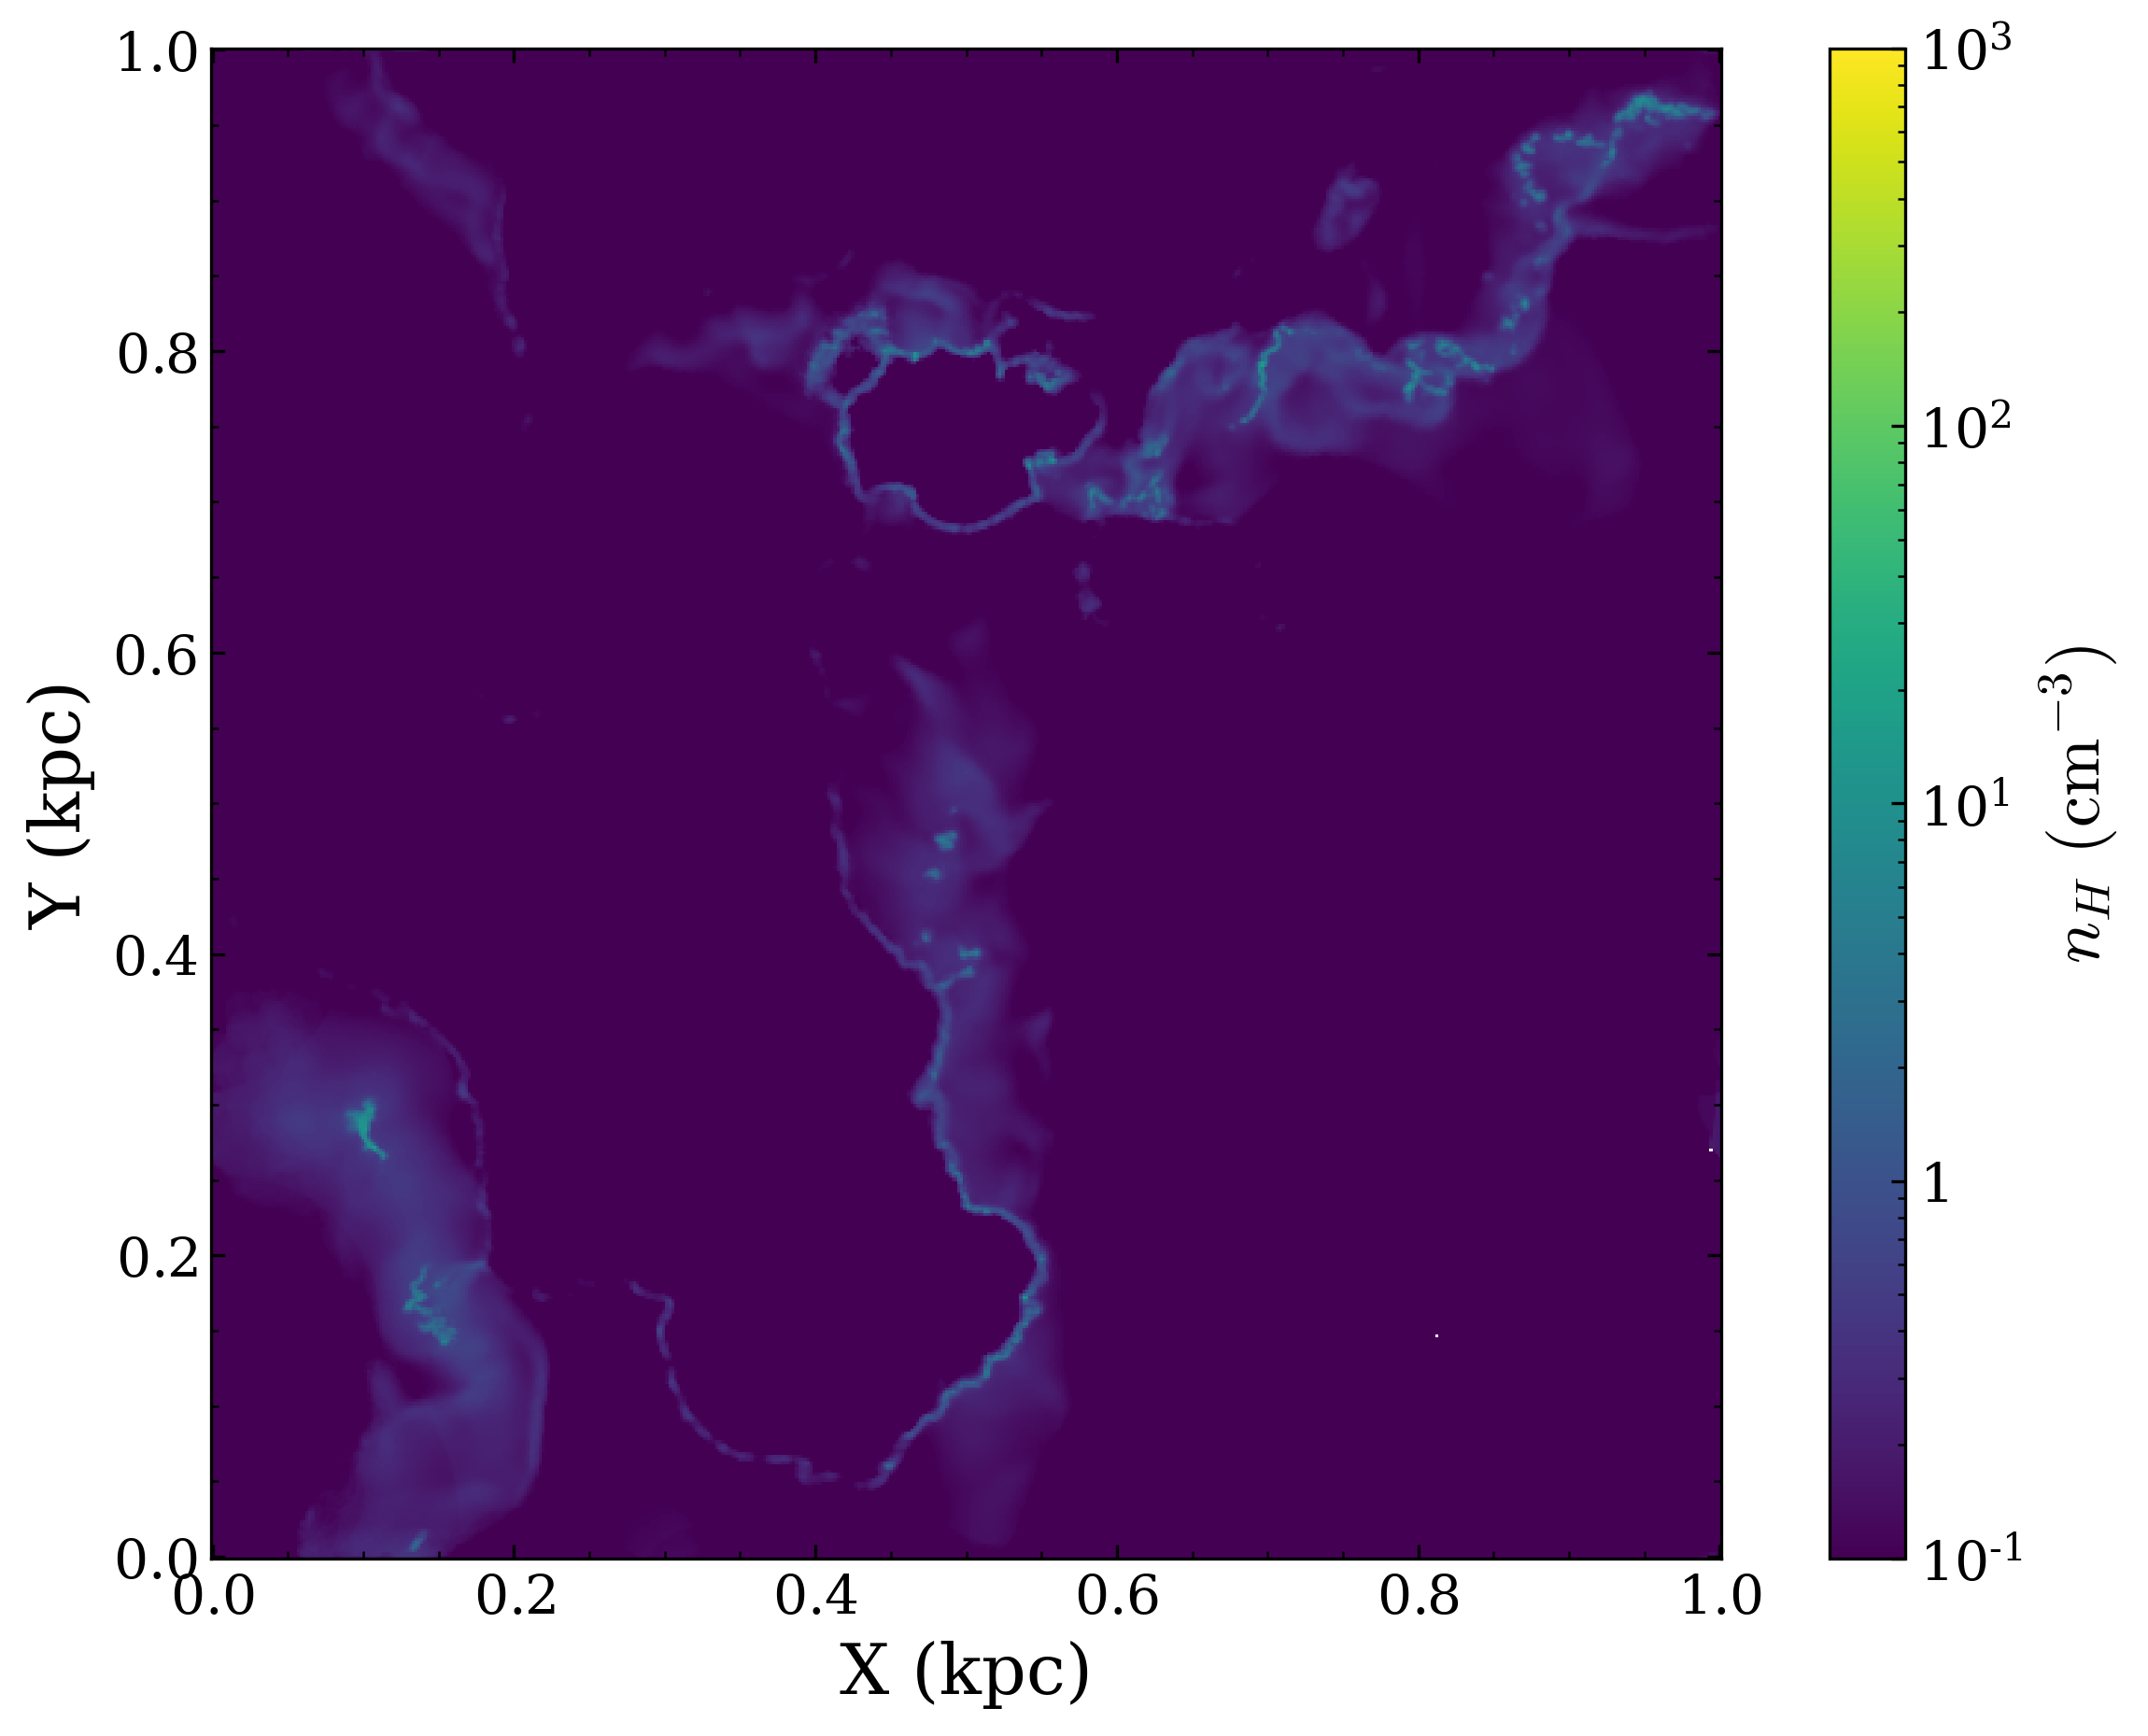

In [17]:
# Slice
zslice = 300
density_slice_nHcgs = np.transpose(rho_volume_weighted_grid[:,:,zslice]) * 300 # *300 for unit conversion
# Plot
fig, ax = plt.subplots(figsize=(10,7))
p = ax.pcolormesh(X, Y, density_slice_nHcgs, norm=colors.LogNorm(vmin=.1,vmax=1e3))
ax.set_aspect('equal')
fig.colorbar(p,label=r"$n_H$ $(\rm cm^{-3})$")
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.show()

In [9]:
# Volume weighted Temperature
XH = 0.76
mp = 1.67e-24
gamma = 5/3
kb = 1.38e-16
mu = 4/(1 + 3*XH + 4*XH*xe) * mp
T = (gamma - 1)*u/kb * 10**10 * mu
# Voxelize
temp_grid = Voxelize.__call__(self=Voxelize, box_L=1, coords=pos, radii=R, field=T, box=512)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
root_add_process : started ...
workers_process : started ...
workers using 35 threads.
Workers processed 377474037 numbers, of which were
	0.000e+00 exact calculations (R<Rmin),
	3.333e+08 exact calculations (R>Rmax),
	4.415e+07 trivial calculations,
	0.000e+00 interpolations.

workers_process : ended.
Root processed 377474037 numbers in 11537 CPU-chunks.
root_add_process : ended.
voxelize_gpu function took 69.2351 seconds
In the end, 0 in cpu_queue


In [13]:
# Get volume weighted grid (in my theory)
temp_volume_weighted_grid = temp_grid / count_grid

/tmp/ipykernel_645435/2954273011.py:2: RuntimeWarning: invalid value encountered in true_divide
  temp_volume_weighted_grid = temp_grid / count_grid


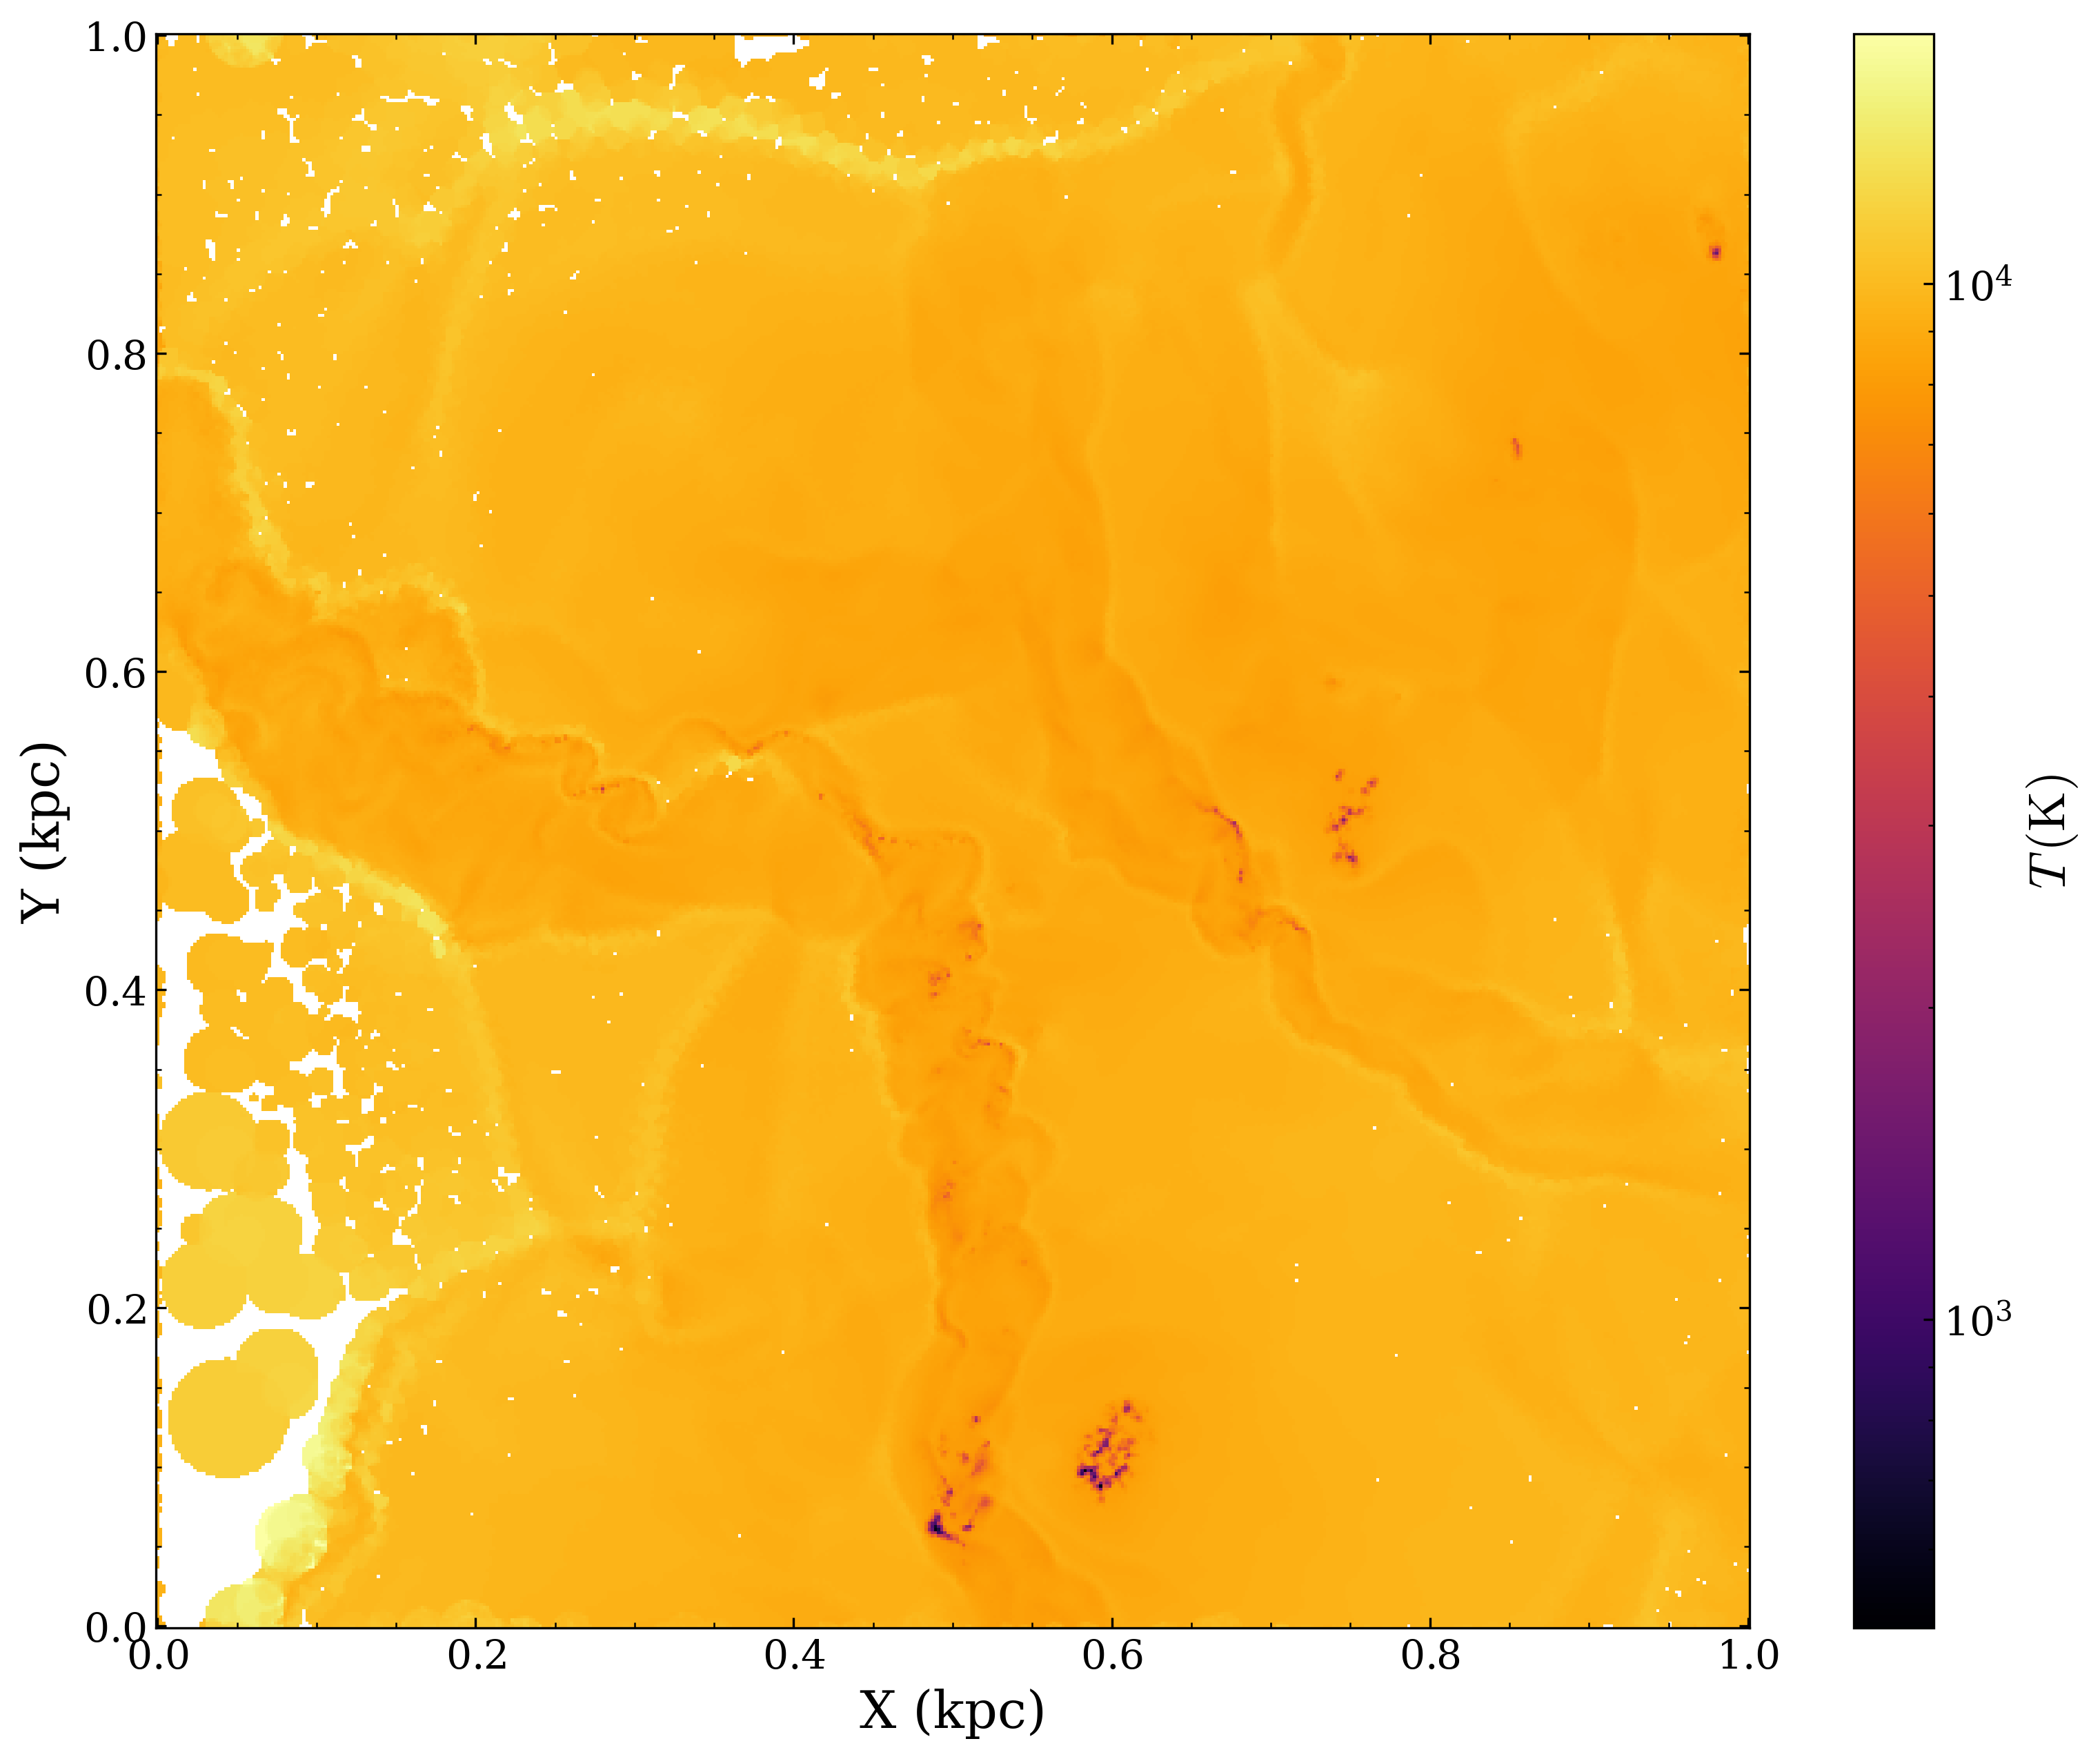

In [14]:
# Slice
zslice = 288
T_K = np.transpose(temp_volume_weighted_grid[:,:,zslice])
# Visualize
fig, ax = plt.subplots(figsize=(13,10))
p = ax.pcolormesh(X, Y, T_K, cmap='inferno',norm=colors.LogNorm())
ax.set_aspect('equal')
fig.colorbar(p,label=r"$T \, (\rm K)$")
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.show()

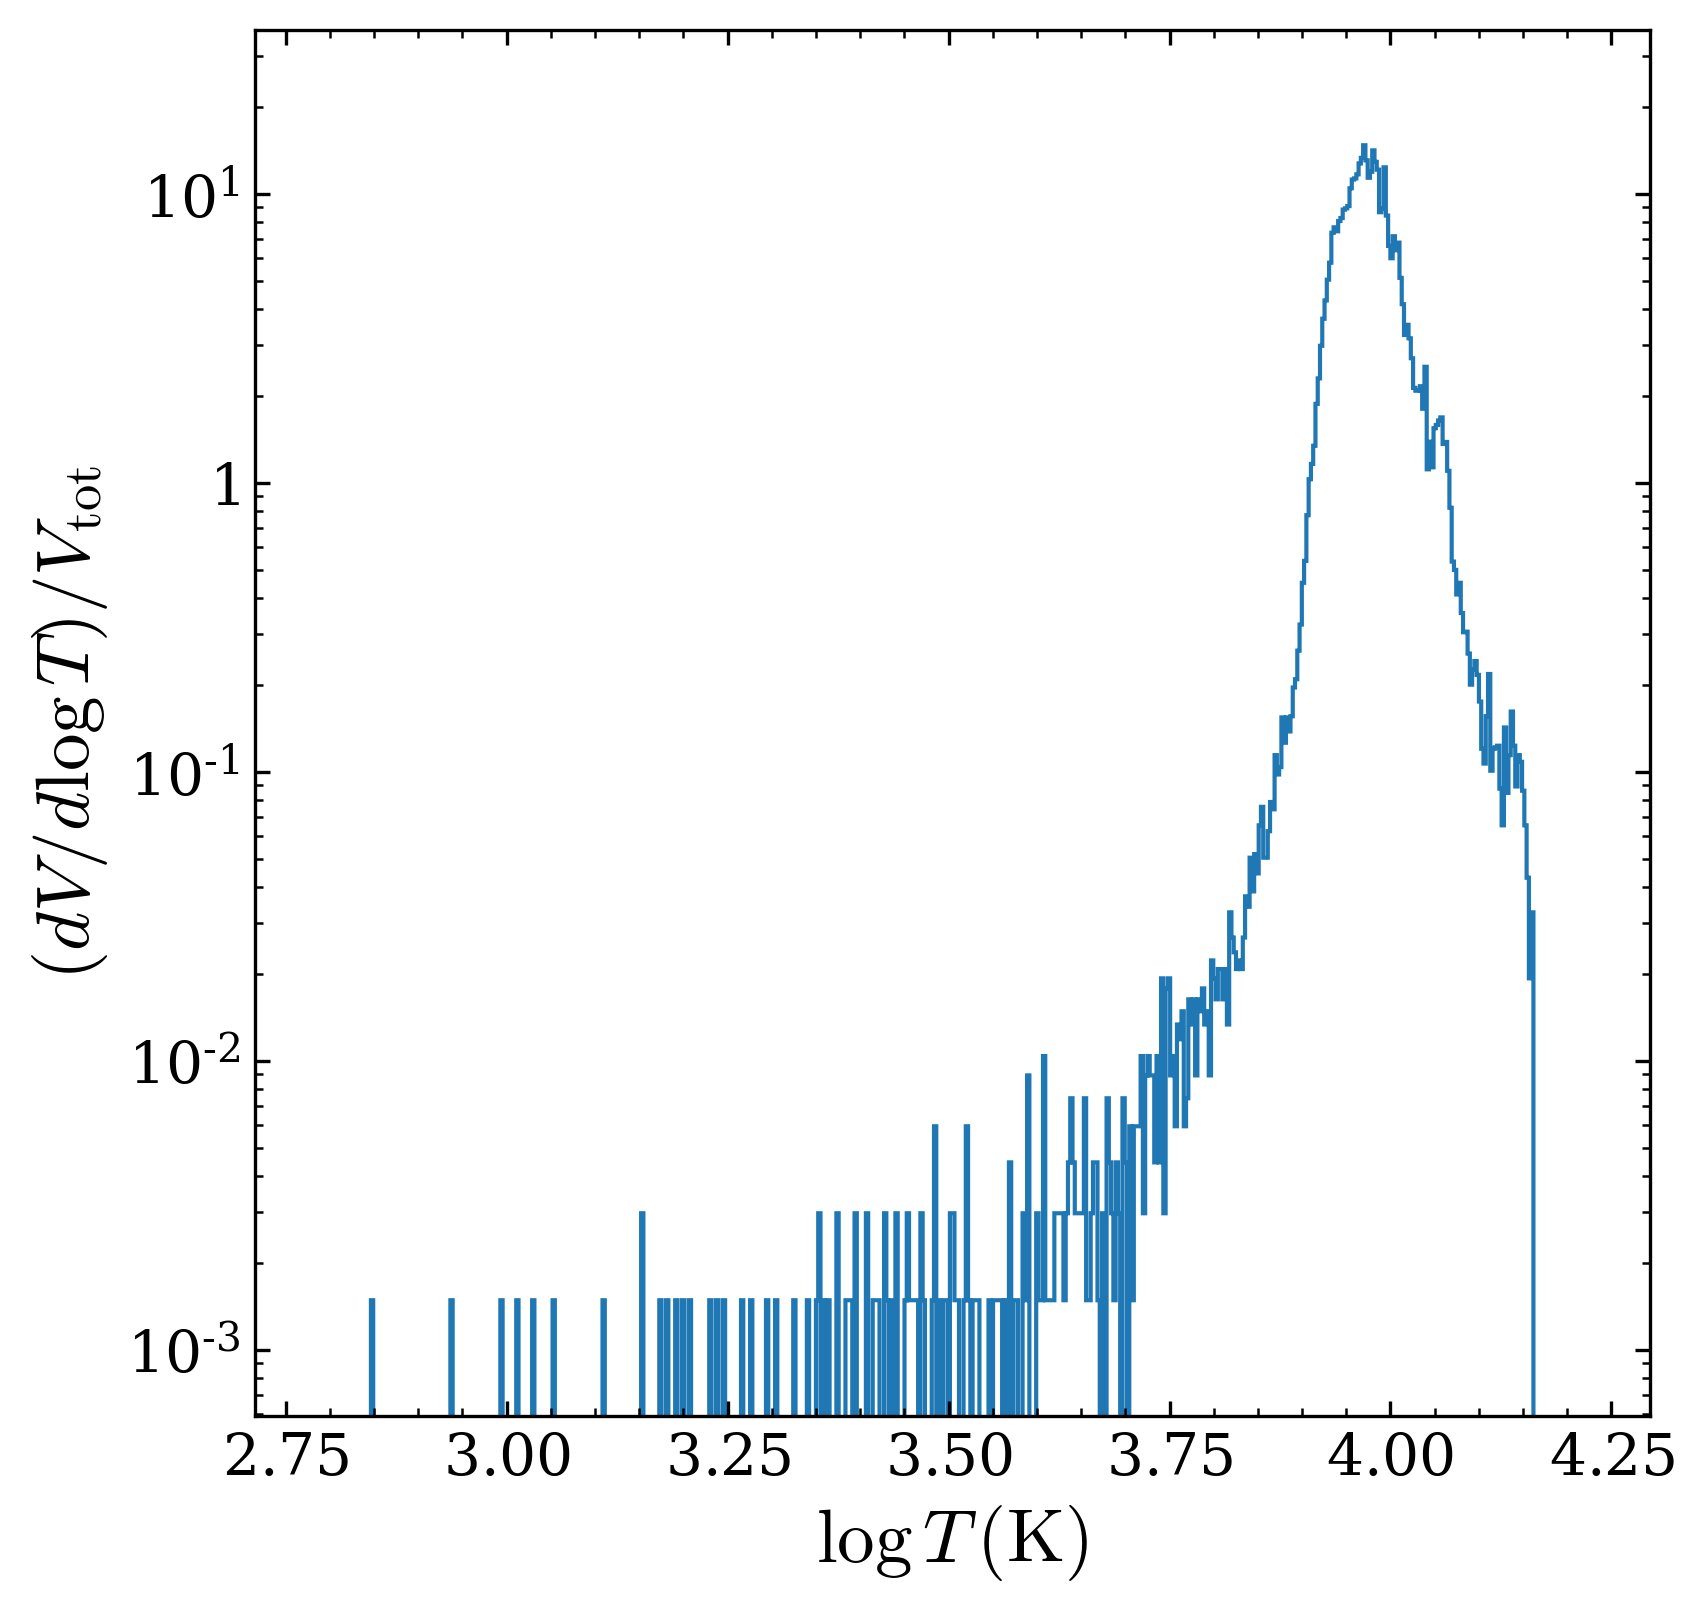

In [29]:
# Temperature PDF # Volume weighted: high-T stands out
plt.hist(np.log10(np.ravel(T_K)), bins=512, density=True, histtype='step', log=True)
plt.xlabel('$\log{T} \, \mathrm{(K)}$')
plt.ylabel('$(dV/d\log{T})/V_\mathrm{tot}$')
# plt.title('Temperature PDF')
plt.show()

In [19]:
# Mass weighted Temperature
XH = 0.76
mp = 1.67e-24
gamma = 5/3
kb = 1.38e-16
mu = 4/(1 + 3*XH + 4*XH*xe) * mp
T = (gamma - 1)*u/kb * 10**10 * mu
# Voxelize
temp_rho_grid = Voxelize.__call__(self=Voxelize, box_L=1, coords=pos, radii=R, field=T*rho, box=512)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
root_add_process : started ...
workers_process : started ...
workers using 35 threads.
Workers processed 1906631991 numbers, of which were
	0.000e+00 exact calculations (R<Rmin),
	1.279e+09 exact calculations (R>Rmax),
	6.279e+08 trivial calculations,
	0.000e+00 interpolations.

workers_process : ended.
Root processed 1906631991 numbers in 58206 CPU-chunks.
root_add_process : ended.
voxelize_gpu function took 308.0153 seconds
In the end, 0 in cpu_queue


In [20]:
# Get mass weighted grid (in my theory)
temp_mass_weighted_grid = temp_rho_grid / rho_grid

/tmp/ipykernel_602679/1130726484.py:2: RuntimeWarning: invalid value encountered in true_divide
  temp_mass_weighted_grid = temp_rho_grid / rho_grid


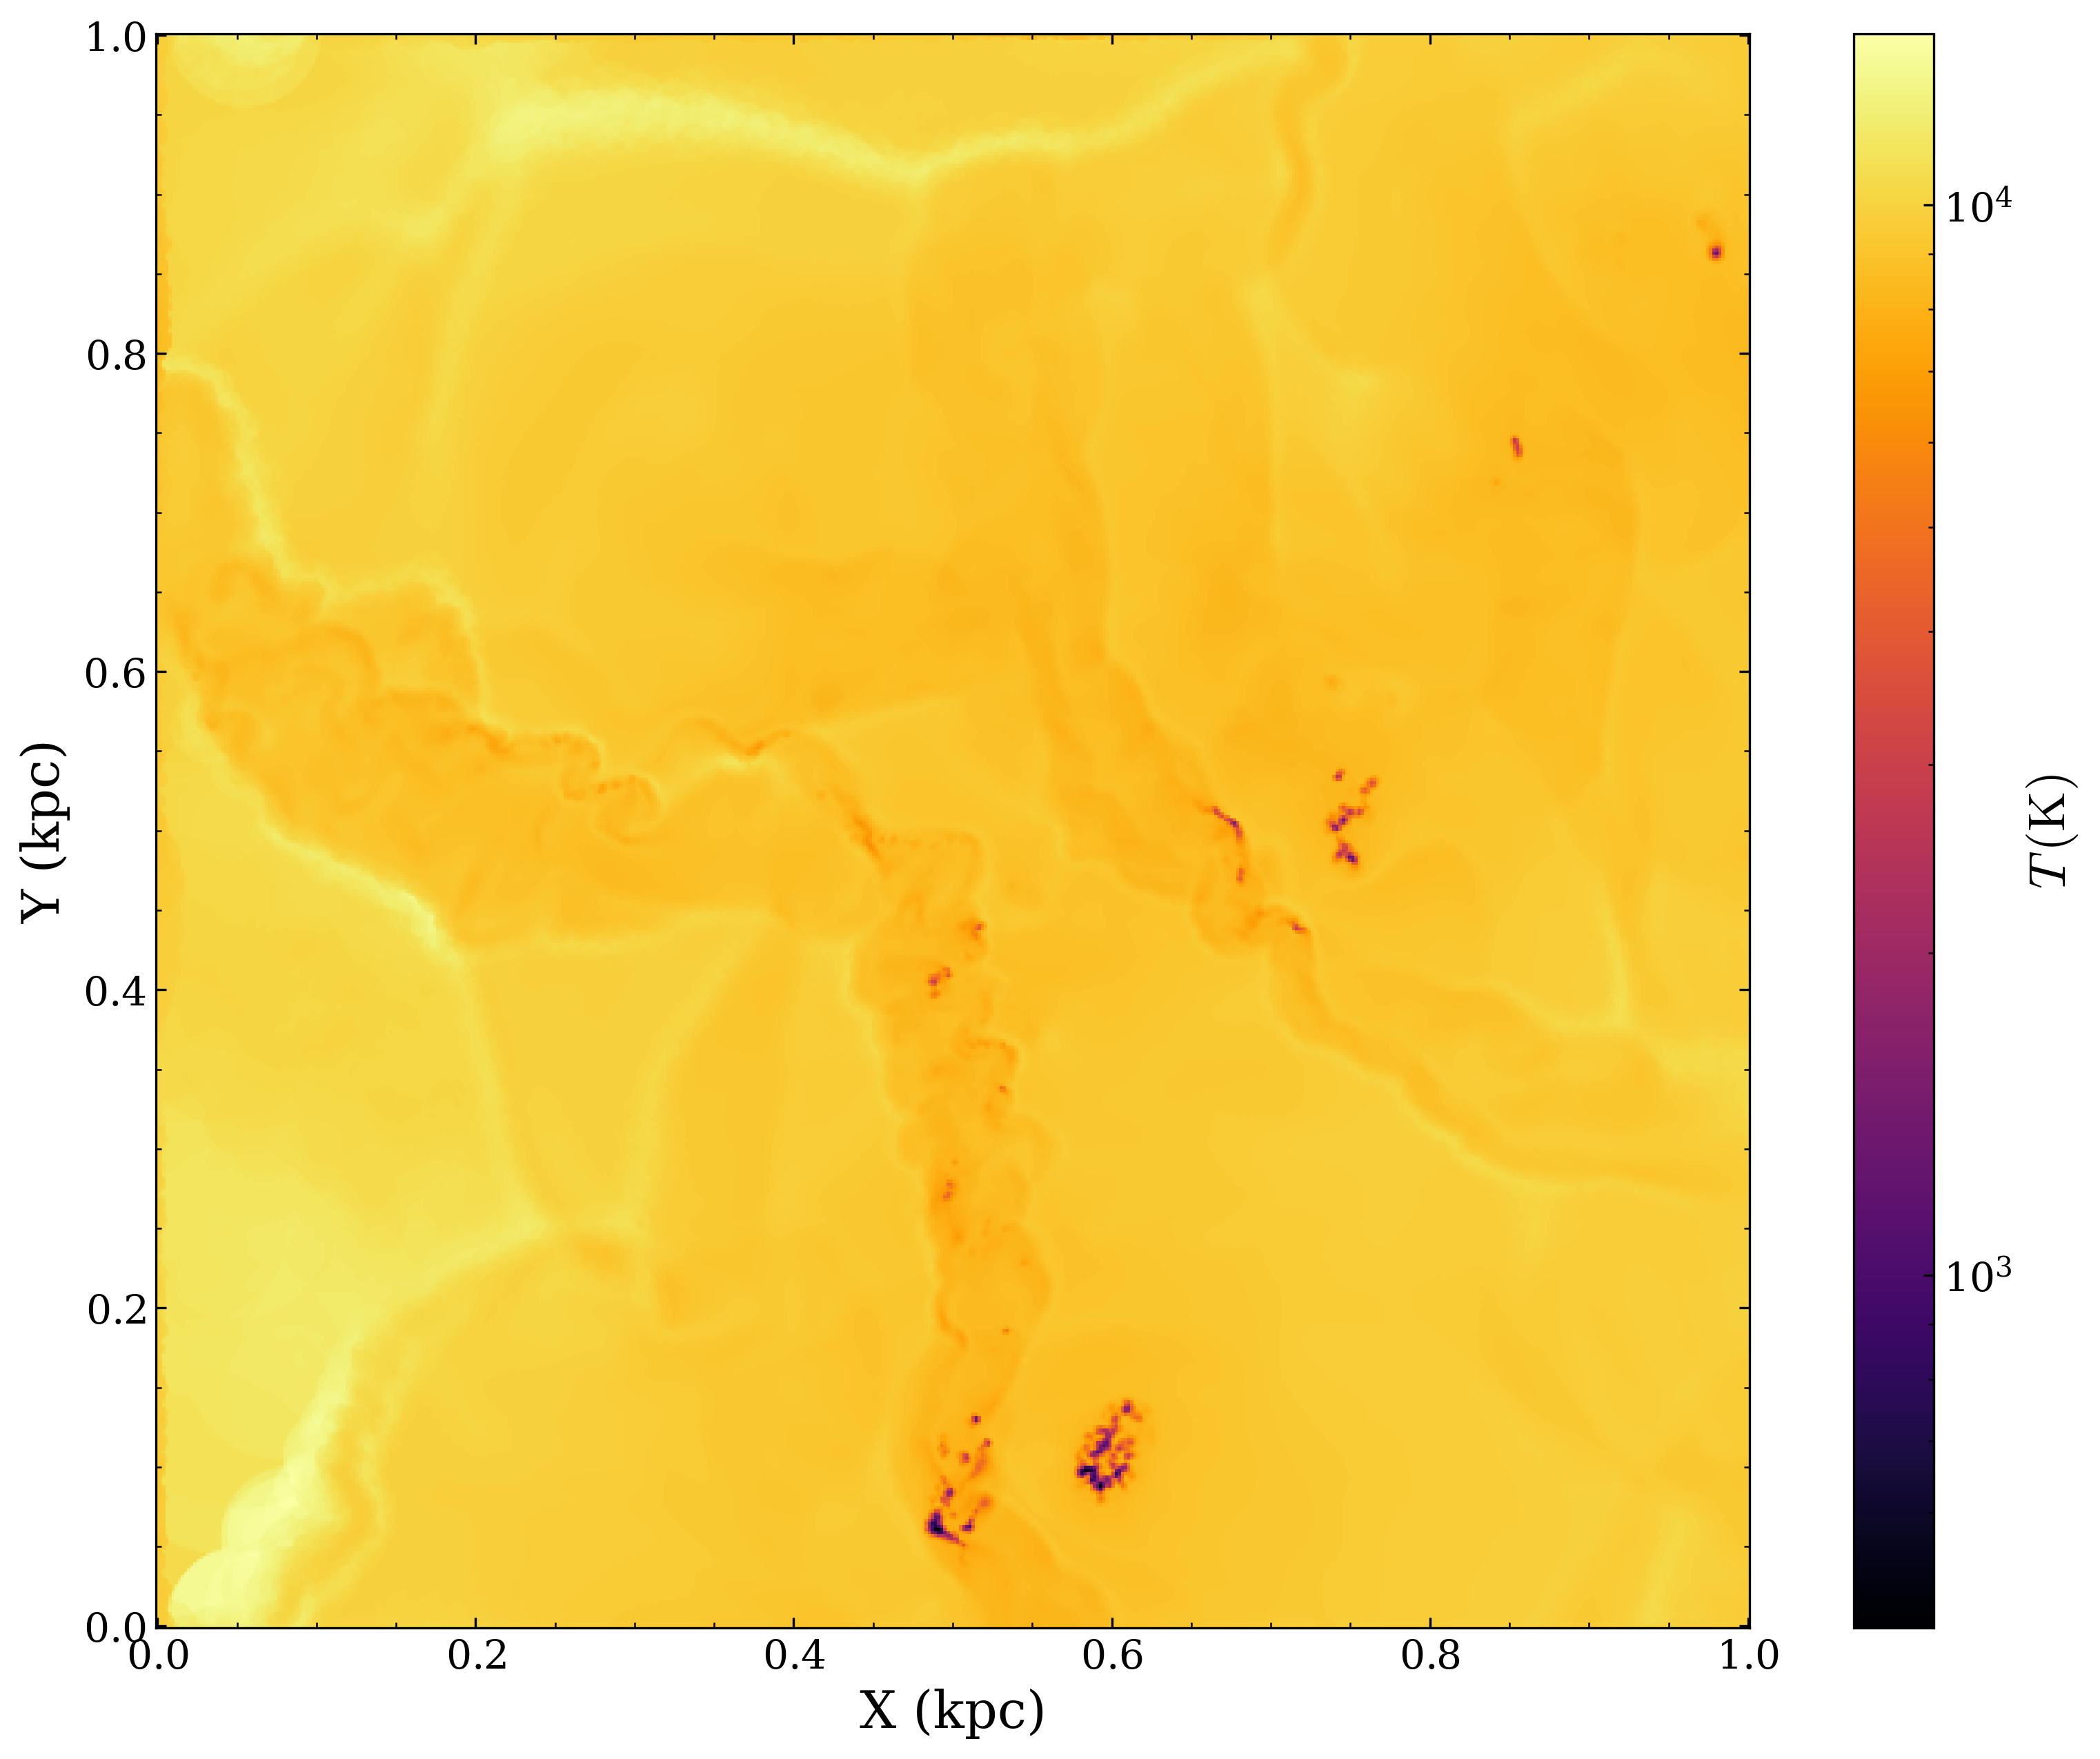

In [21]:
# Slice
zslice = 288
T_K_mass = np.transpose(temp_mass_weighted_grid[:,:,zslice])
# Visualize
fig, ax = plt.subplots(figsize=(13,10))
p = ax.pcolormesh(X, Y, T_K_mass, cmap='inferno',norm=colors.LogNorm())
ax.set_aspect('equal')
fig.colorbar(p,label=r"$T \, (\rm K)$")
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.show()

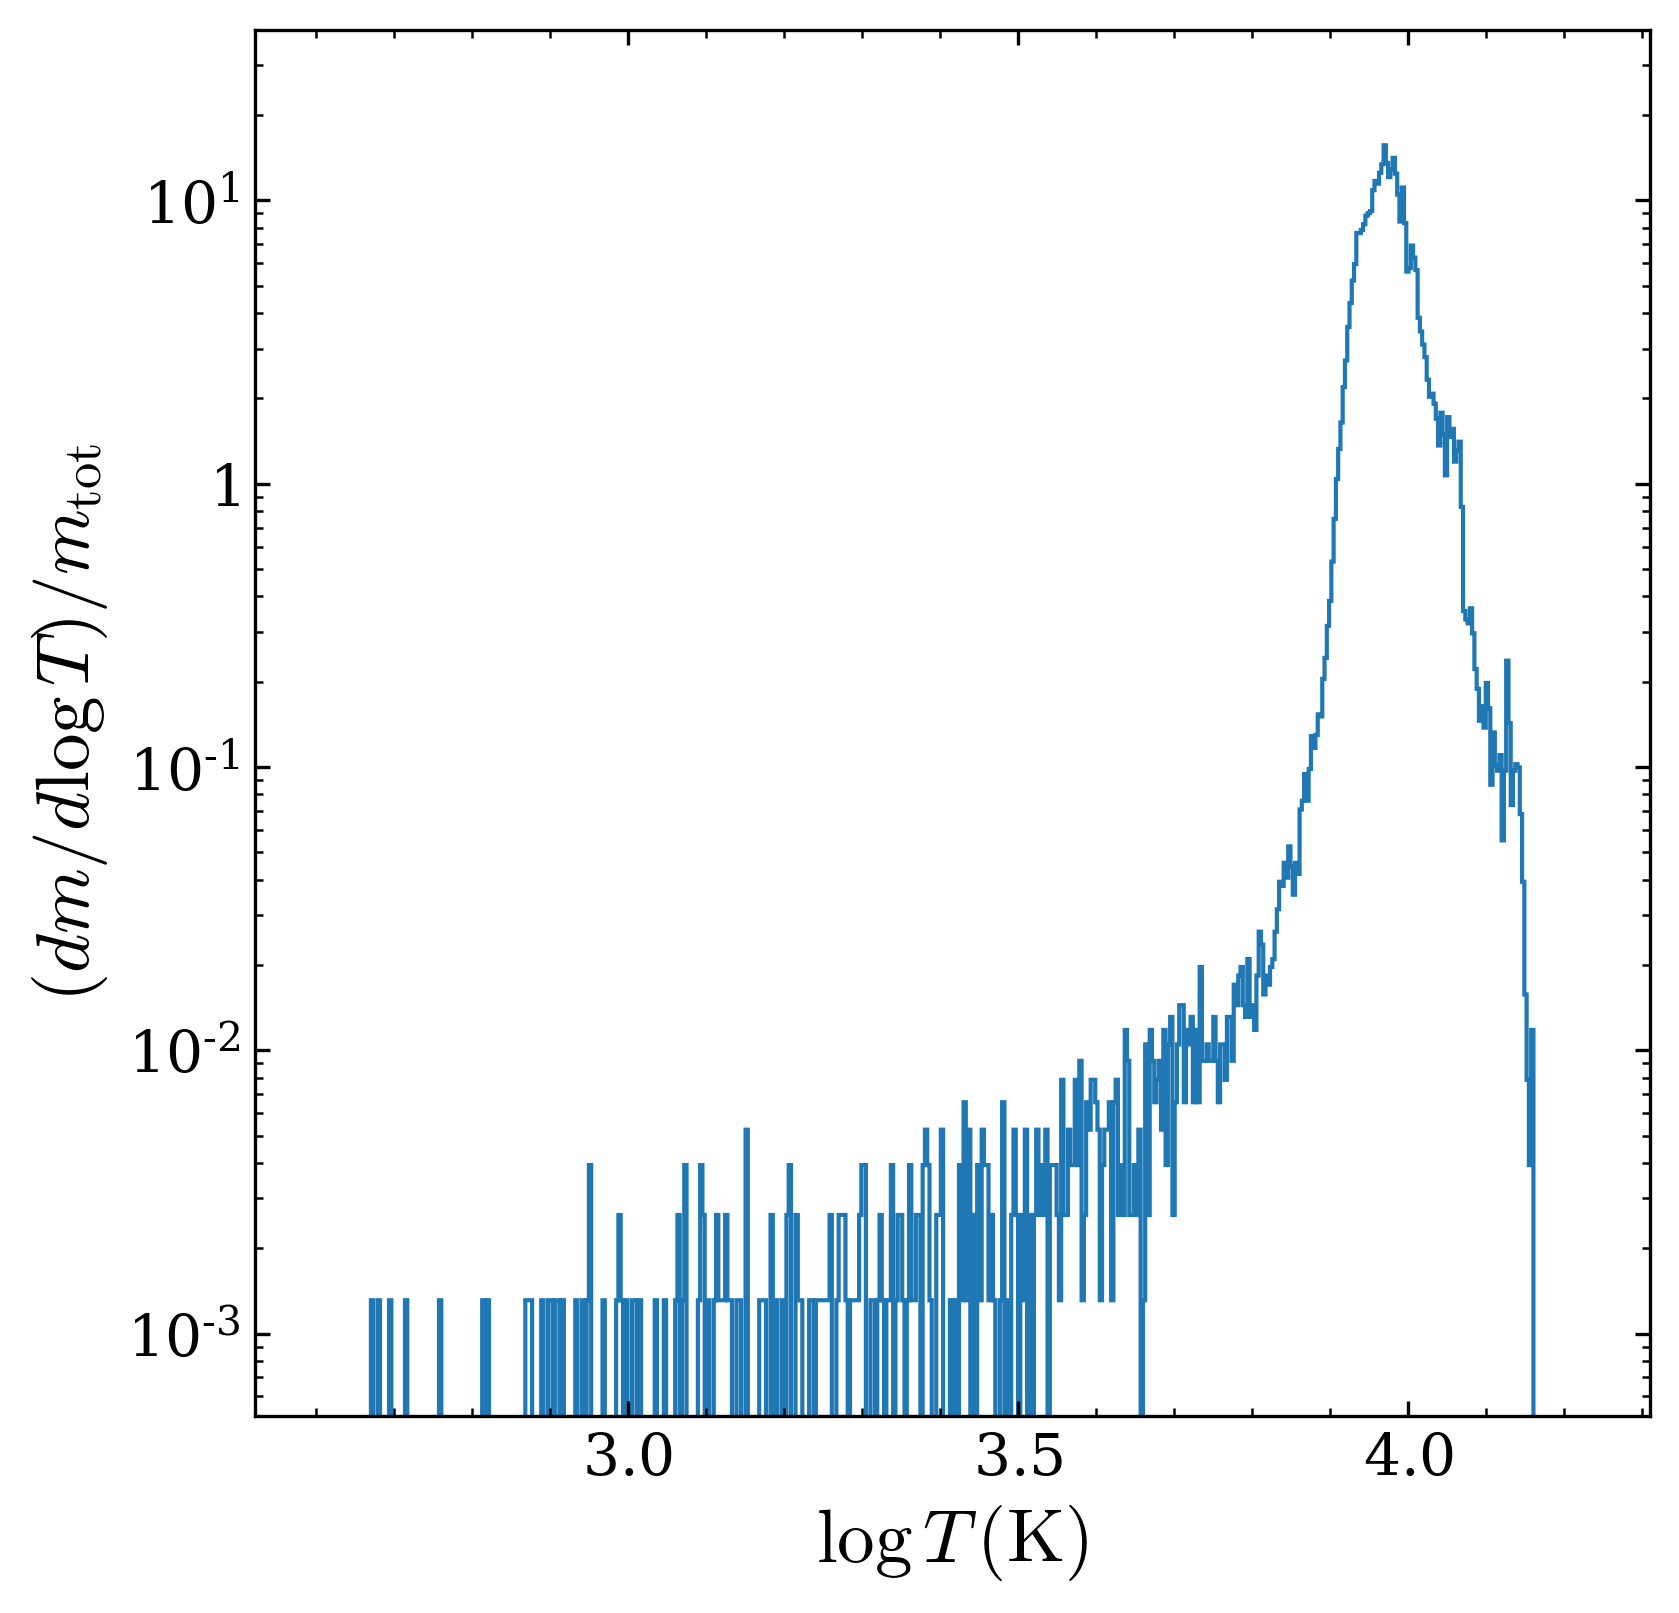

In [23]:
# Temperature PDF # Mass weighted: low-T stands out
plt.hist(np.log10(np.ravel(T_K_mass)), bins=512, density=True, histtype='step', log=True)
plt.xlabel('$\log{T} \, \mathrm{(K)}$')
plt.ylabel('$(dm/d\log{T})/m_\mathrm{tot}$')
# plt.title('Temperature PDF')
plt.show()

Interp $v^2\rho/m$ to preserve $\sum_i v^2_i = \sum_\alpha v^2_\alpha$

In [4]:
Lbox = 1.
Nsize = 512

In [5]:
# mass fixed, reduce V, increase rho -> mass point distribution
ratio = 1e5
rho *= ratio
V = mass / rho
R = ((3*V)/(4*np.pi))**(1/3)

In [6]:
vrho_m = v.copy()
vrho_m[:,0] = vrho_m[:,0] * rho / mass
vrho_m[:,1] = vrho_m[:,1] * rho / mass
vrho_m[:,2] = vrho_m[:,2] * rho / mass

In [7]:
v_grid = Voxelize.__call__(self=Voxelize, box_L=1, coords=pos, radii=R, field=vrho_m, box=512)
Lcell = Lbox / Nsize
v_grid *= Lcell**3

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
root_add_process : started ...
workers_process : started ...
workers using 35 threads.
Workers processed 11893786 numbers, of which were
	0.000e+00 exact calculations (R<Rmin),
	2.926e+06 exact calculations (R>Rmax),
	8.968e+06 trivial calculations,
	0.000e+00 interpolations.

workers_process : ended.
Root processed 11893786 numbers in 385 CPU-chunks.
root_add_process : ended.
voxelize_gpu function took 1.4775 seconds
In the end, 0 in cpu_queue


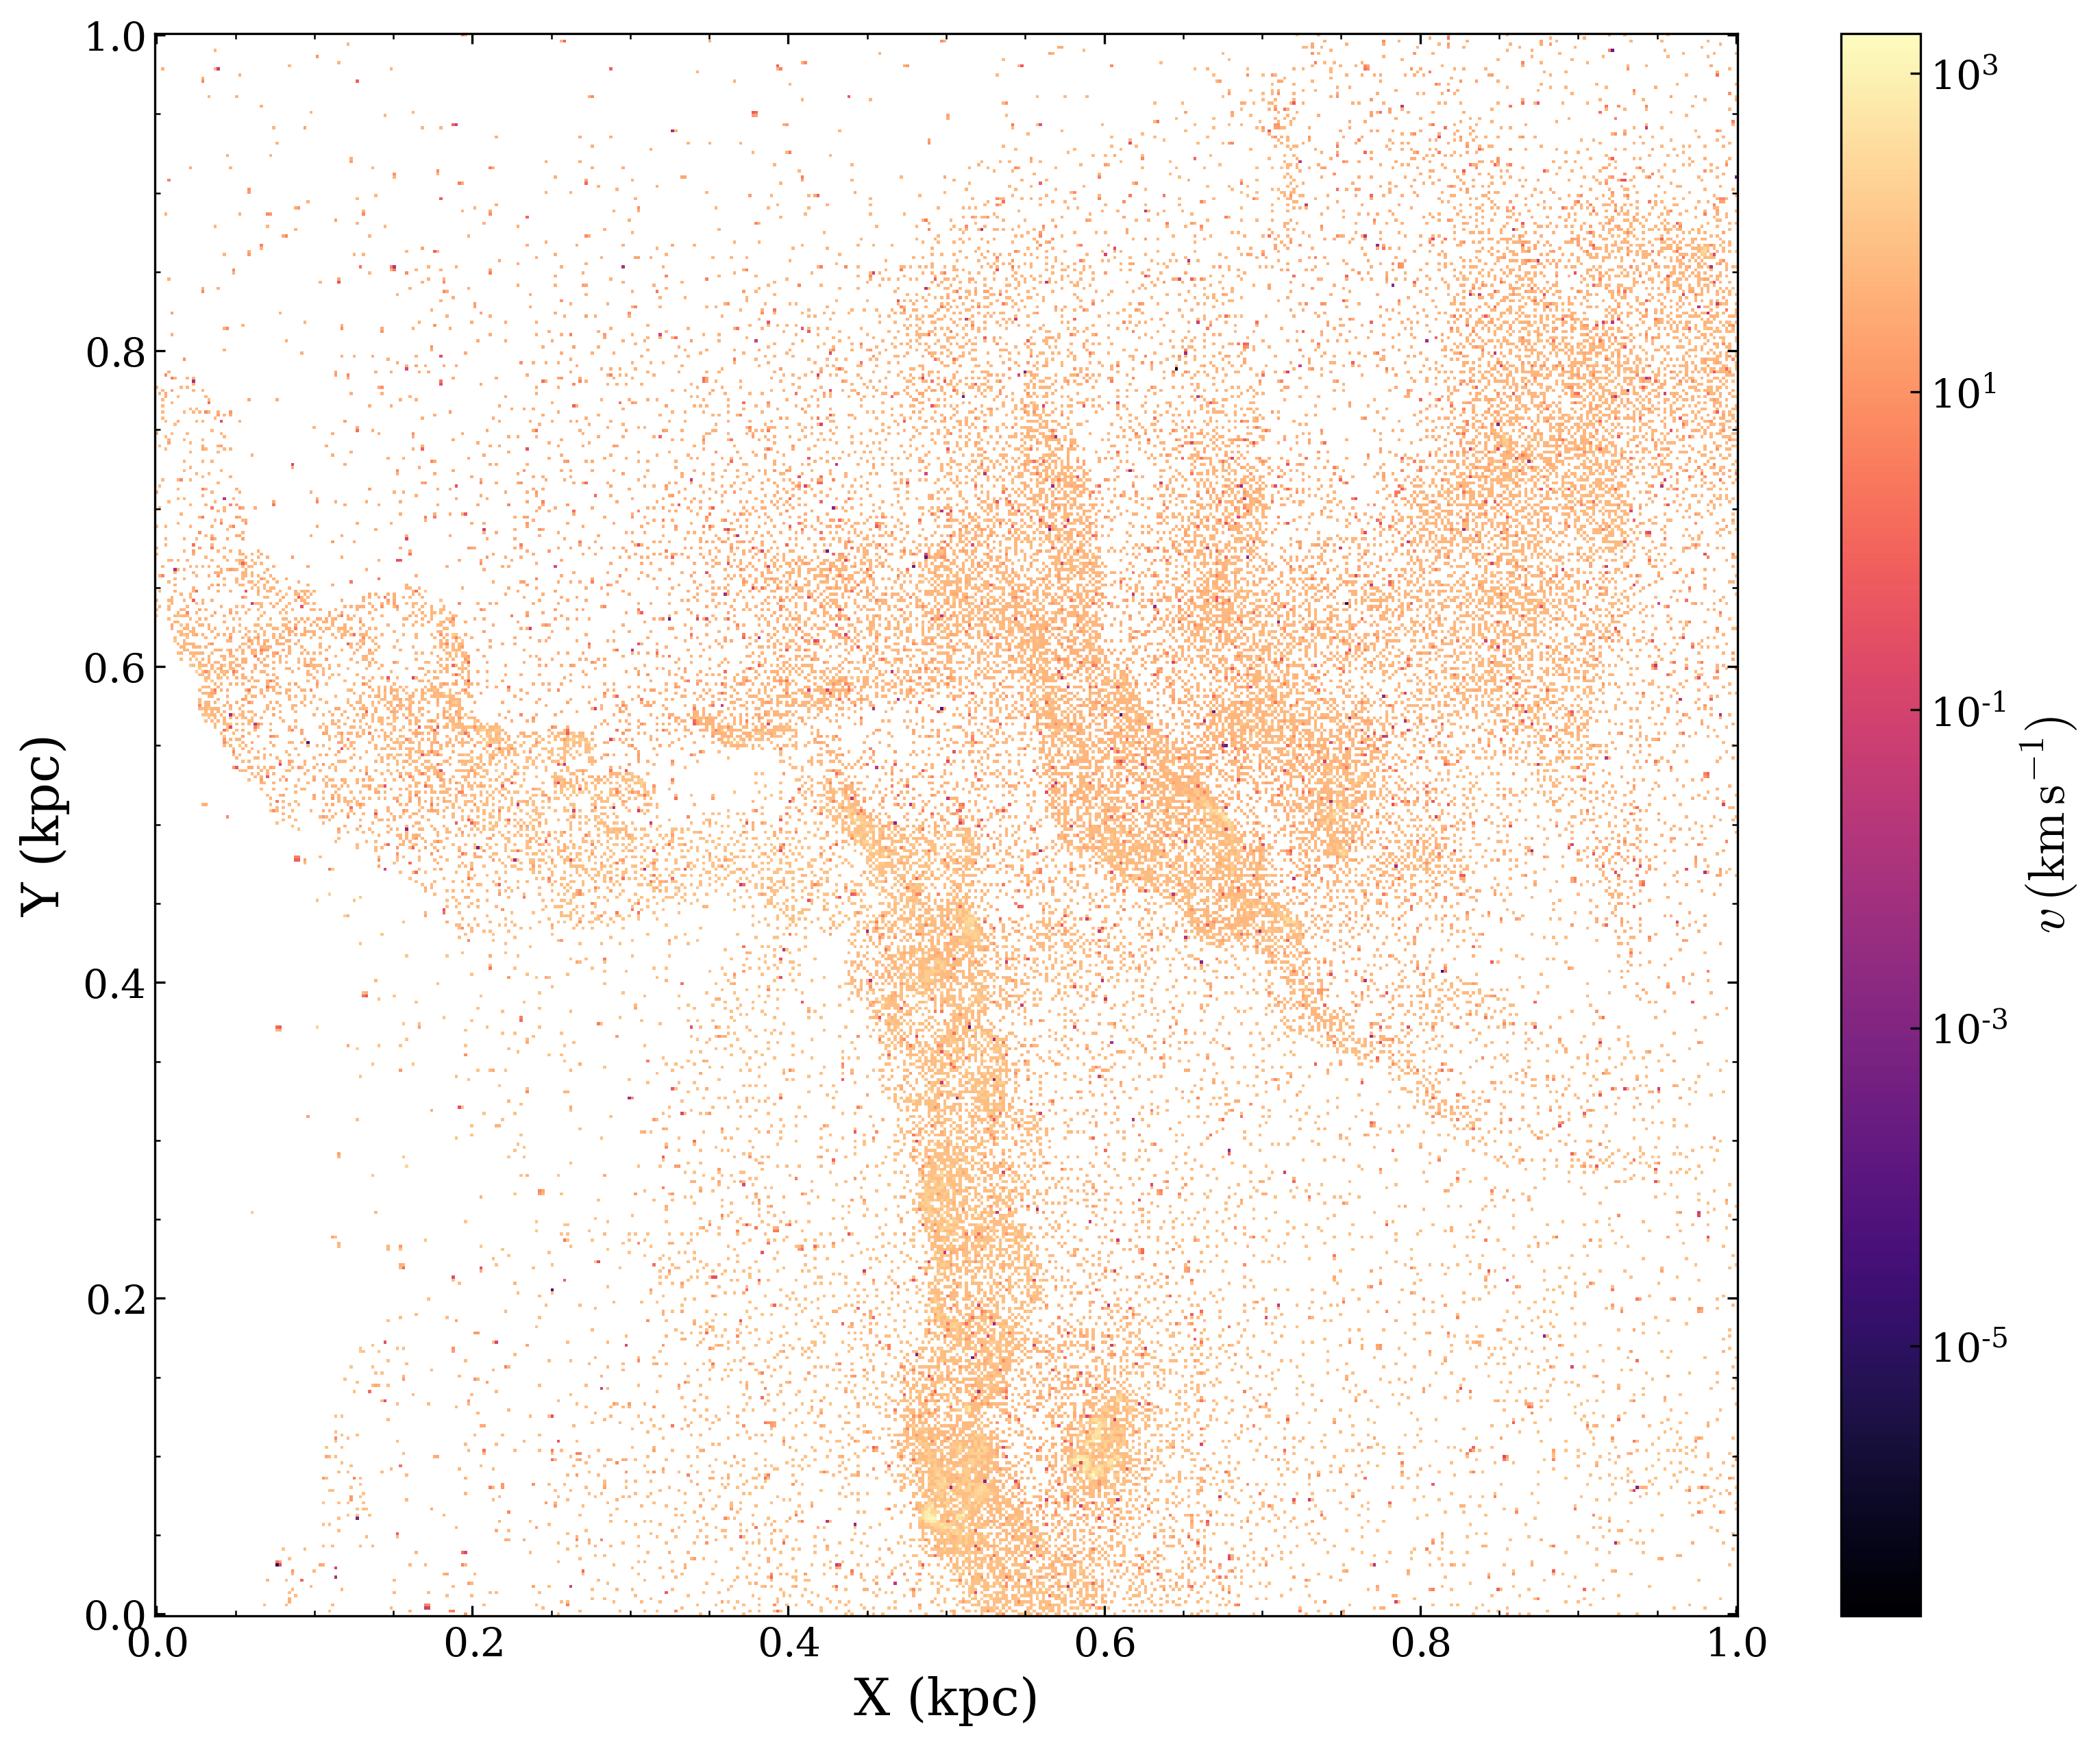

In [10]:
# Slice
zslice = 288
vx_kms = np.transpose(v_grid[:, :, zslice, 0])
# Visualize
fig, ax = plt.subplots(figsize=(13,10))
p = ax.pcolormesh(X, Y, vx_kms, cmap='magma', norm=colors.LogNorm())
ax.set_aspect('equal')
fig.colorbar(p,label=r"$v \, (\rm km\,s^{-1})$")
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.show()